In [1]:
import pandas as pd
import numpy as np
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
from pylab import rcParams 
rcParams['figure.figsize'] = 10, 15

# Создадим таблички для наглядности :)

In [2]:
# values = [[1,55.737564,37.345186], [2,56.234564,37.234590], [3,55.234578,36.295745]]
# columns = ['user_id','loc_lat','loc_lon']
# user_coordinates = pd.DataFrame(data=values, columns=columns)
# user_coordinates.to_csv('user_coordinates.csv',index=False)
values = [[1,55.748021999999994, 37.786073], [2,55.752564,37.784841], [3,55.752564,37.781341]]
columns = ['user_id','loc_lat','loc_lon']
user_coordinates = pd.DataFrame(data=values, columns=columns)
user_coordinates.to_csv('user_coordinates.csv',index=False)

In [3]:
values = [[1,55.747022,37.787073,0], 
          [1,55.751713,37.784328,1], 
          [1,55.753878,37.777638,2], 
          [1,55.751031,37.779351,3], 
          [2,55.803885,37.458311,0],
          [2,55.808677,37.464054,1],
          [2,55.809763,37.461314,2],
          [2,55.810840,37.458654,3]]
columns = ['place_id', 'loc_lat', 'loc_lon', 'point_number']
place_zone_coordinates = pd.DataFrame(data=values, columns=columns)
place_zone_coordinates.to_csv('place_zone_coordinates.csv',index=False)

# Импорт данных

In [4]:
user_coordinates = pd.read_csv('user_coordinates.csv')
user_coordinates.head()

,user_id,loc_lat,loc_lon
0,1,55.748022,37.786073
1,2,55.752564,37.784841
2,3,55.752564,37.781341


In [5]:
place_zone_coordinates = pd.read_csv('place_zone_coordinates.csv')
place_zone_coordinates.head()

,place_id,loc_lat,loc_lon,point_number
0,1,55.747022,37.787073,0
1,1,55.751713,37.784328,1
2,1,55.753878,37.777638,2
3,1,55.751031,37.779351,3
4,2,55.803885,37.458311,0


# Решение

Подразумевается, что полигон замкнутый, и в общем случае ребра многоугольника не пересекаются друг с другом, то есть в нем нет самопересечений. Сложность алгоритма определяющего пренадлежит ли точка(клиент) многоугольнику(зоне доставки) будет $O(n)$ где $n$ - количество ребер в многоугольнике.

In [6]:
place_zone_coordinates.sort_values(['place_id', 'point_number'], inplace=True) #Если вдруг точки не по порядку
place_zone_coordinates

,place_id,loc_lat,loc_lon,point_number
0,1,55.747022,37.787073,0
1,1,55.751713,37.784328,1
2,1,55.753878,37.777638,2
3,1,55.751031,37.779351,3
4,2,55.803885,37.458311,0
5,2,55.808677,37.464054,1
6,2,55.809763,37.461314,2
7,2,55.810840,37.458654,3


Преобразуем в другой формат данных для удобства

In [7]:
place_zone_coordinates['point'] = list(zip(place_zone_coordinates['loc_lat'] , place_zone_coordinates['loc_lon']))
user_coordinates['point'] = list(zip(user_coordinates['loc_lat'] , user_coordinates['loc_lon']))
df = place_zone_coordinates.groupby('place_id')['point'].apply(list).reset_index(name='coords')
df['path'] = df['coords'].apply(mplPath.Path)
df.head()

,place_id,coords,path
0,1,"[(55.747021999999994, 37.787073), (55.751713, ...","Path(array([[55.747022, 37.787073],\n [5..."
1,2,"[(55.803885, 37.458311), (55.808677, 37.464054...","Path(array([[55.803885, 37.458311],\n [5..."


Метод трассировки лучей: пускаем луч из точки и считаем кол-во пересечений с ребрами многогольника.
Если нечетное то попадает в многоугольник если четное то нет. (Из-за погрешностей вычислений чисел с плавающей точкой могут быть невеные ответы, также есть особые случаи: пересечение лучом вершины многоугольника или ребра, которое частично совпадает с лучом, также может привести к неверному ответу)

In [8]:
def ray_tracing_method(x, y, poly):
    n = len(poly) 
    inside = False
    p1x, p1y = poly[0]
    for i in range(n+1): 
        p2x, p2y = poly[i % n] 
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y
    return inside

In [9]:
def get_number_of_places_my_func(point, polygon):
    temp = polygon['coords'].apply(lambda polygon: ray_tracing_method(point[0], point[1], polygon))
    return temp.sum()

Также можем воспользоваться contains_point() из matplotlib.path для определения принадлежности точки многоугольнику :)


In [10]:
def get_number_of_places(point, polygon):
    temp = polygon['path'].apply(lambda polygon: polygon.contains_point(point, radius=-0.000000001))
    return temp.sum()

Подсчет количества доступных ресторанов.

In [11]:
user_coordinates['number_of_places_available'] = user_coordinates['point'].apply(lambda point: get_number_of_places(point, df))

In [12]:
# user_coordinates['number_of_places_my_func'] = user_coordinates['point'].apply(lambda point: 
#                                                                                get_number_of_places_my_func(point, df))

In [13]:
user_coordinates

,user_id,loc_lat,loc_lon,point,number_of_places_available
0,1,55.748022,37.786073,"(55.74802199999999, 37.786072999999995)",1
1,2,55.752564,37.784841,"(55.752564, 37.784841)",0
2,3,55.752564,37.781341,"(55.752564, 37.781341)",1


Сохраним ответ

In [14]:
user_coordinates[['user_id', 'number_of_places_available']].to_csv('answer.csv', index=False)

In [15]:
answer = pd.read_csv('answer.csv')
answer.head()

,user_id,number_of_places_available
0,1,1
1,2,0
2,3,1


Визуализируем полигон и точки для частичной проверки

In [16]:
x = list(np.array(df['coords'][0])[:, 0])
x.append(np.array(df['coords'][0])[:, 0][0])
y = list(np.array(df['coords'][0])[:, 1])
y.append(np.array(df['coords'][0])[:, 1][0])

In [17]:
x_p = np.array(user_coordinates['loc_lat'])
y_p = np.array(user_coordinates['loc_lon'])

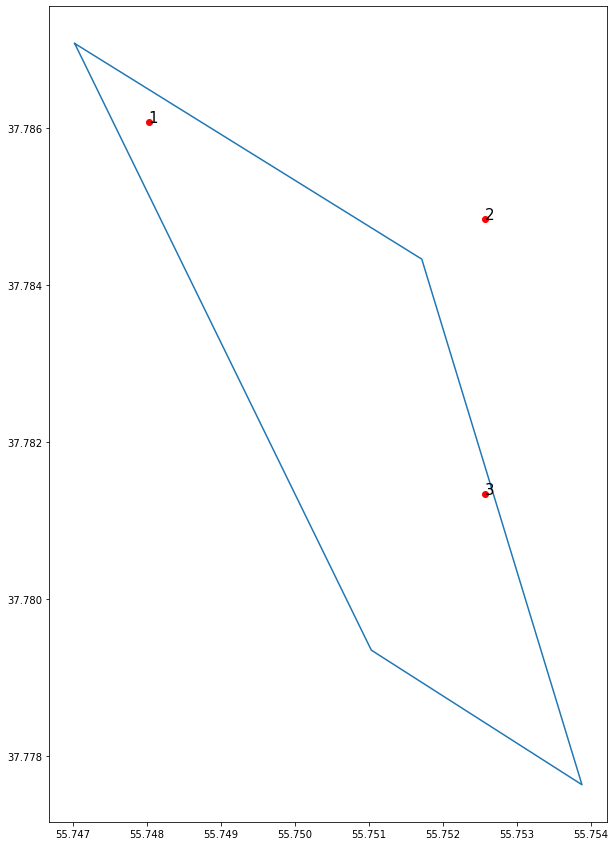

In [18]:
plt.scatter(x_p, y_p, color='red')
for user in user_coordinates.values: 
    plt.annotate(user[0], (user[1], user[2]), size=15)
plt.plot(x, y)
plt.show()